# A basic example - Washington 14-bus grid system

## Placeholder, write full example End of February

In the following introductory example, a power grid with 14 busses will be used to display the features and capabilities of reXplan. To fully model and calculate the resiliency of specified power grids, three datasets are needed:

- [Power Grid Data](../modeling/in_grid_modeling.md)
- [Fragility Curves](../modeling/in_fragility_curve.md)
- [Hazard Definition](../modeling/in_hazard_modeling.md)

To see a more detailed introduction for the input data, see **(I/0) - Input tab** under the 🌐**MODELING** sidebar. For this example grid, the datasets are already provided and for the hazard modeling the methodology of return periods is used.

## Step 1: Library and Data Import

As reXplan utilizes Jupyter Notebook, code sequences can be subdivided into multiple windows.
Common practise is to keep the imports and the initialization seperated, which allows the user to make adjustments to python libraries without re-running the full code.

In [1]:
# importing reXplan and dependencies
import reXplan as rx
import numpy as np
import warnings
from pandapower.plotting.plotly import pf_res_plotly
warnings.simplefilter("ignore") # warning are ignored for now

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# calling data from folder 'basic_example_tim'
simulationName = 'basic_example_tim';
network = rx.network.Network(simulationName);
simulation = rx.simulation.Sim(simulationName);

In [2]:
# TODO EXECUTE THIS, HIDDEN IN DOCS
simulationName = 'basic_example_tim';
network = rx.network.Network(simulationName);
simulation = rx.simulation.Sim(simulationName);

Duration of simulation is 40 timesteps.
Start of hazard at timestep 12, end at timestep 17 (duration: 5 timesteps)


The classes of network and simulations are shortened to variables [network](../functions/userfunctions.md#network) & [simulation](../functions/userfunctions.md#simulation) for better readability.

### Assess datasets pre-simulation

Since the network is now created, different datasets can be printed. As previously described, the user can now assess the power grid data, fragility curves and hazard and thus verify the input data.

#### [Power Grid (pre run)](../modeling/in_grid_modeling.md)

With the use of the [plotly function of PandaPower](https://pandapower.readthedocs.io/en/v2.13.1/plotting/plotly/built-in_plots.html#power-flow-results), the network can be printed.

In [ ]:
# printing power grid with pandapower
pf_res_plotly(network.pp_network);

The spatial information is displayed as provided in the power grid dataset. Power Flow is calculated and results can be analyzed by hovering over the relating element with the cursor.

#### [Fragility Curve](../modeling/in_fragility_curve.md)

In [ ]:
# xnew creates user defined range for interpolation (0->85)
sns.set(rc={'figure.figsize':(6,5)})
xnew = np.linspace(0, 90, num=100, endpoint=True)
fig, ax = rx.fragilitycurve.plotFragilityCurves(network.fragilityCurves, xnew)
plt.xlim(0, 90)

As displayed above, the provided datasets include two different fragility curves for different types of towers. On the horizontal axis, the intensity is displayed as a numerical value in an interval from 0 to 90 with the use of [linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html). The intensity translates to windspeed in m/s. On the vertical axis, the probability of failure is shown as a decimal fraction, which translates to the probability of failure in percentage (0.5 = 50%). 

<div class="alert alert-info">

Note

The fragility curve has to refer to the same intensity type as the hazard model.
</div>

For this example, the intensity type is windspeed measured in m/s.

There is also a possibility to print a fragility curve individually. More information provided under [Fragility Curve](../modeling/in_fragility_curve.md). 

#### [Printing hazards as a return period](../modeling/in_hazard_modeling.md)

The [hazard modeling](../modeling/in_hazard_modeling.md) in this example case uses a [return period](../modeling/in_hazard_modeling.md#method-4-simulate-multiple-events-according-a-given-return-period).

In [ ]:
# printing return periods
sns.set(rc={'figure.figsize':(10,8)})
for rp in network.returnPeriods.keys():
    sns.lineplot(x=network.returnPeriods[rp].x_data, y=network.returnPeriods[rp].y_data, label=rp)
plt.xlabel('Years')
plt.ylabel('Intensity')
plt.show()

As displayed above, the provided datasets include six different return periods (rp1 - rp6). The highest value for given return periods is considered the `reference return period`. On the vertical axis, the intensity is displayed as a numerical value in an interval from 0 to 3.2 in m/s. On the horizontal axis, the return period is shown as a numerical value in years, which can be used to calculate the annual exceedance probability. 


For instance a 200 Years return period has an annual probability of 1/200 = 0.005% [#TODO Terminology](https://hydro-informatics.com/exercises/ex-floods.html?highlight=return#terminology)

#TODO Mathematical Equation here? TEST RETURN PERIODS FOR INTENSITY

<div class="alert alert-info">

Note

The hazard model has to refer to the same intensity type as the fragility curve.

</div>

## Step 2: Running the Simulation

The following command executes the [simulation](../functions/userfunctions.md#simulation) of the return period "rp6" on the previously described fragility curves. This creates an outage schedule for grid elements. Data is stored in `montecarlo_database.csv`.

In [ ]:
# Initilize for Return Periods
simulation.initialize_model_rp(network=network, ref_return_period="rp3", mc_iteration_factor=10, maxStrata=3)

In [6]:
# EXECUTE THIS, HIDDEN IN DOCS
simulation.initialize_model_rp(network=network, ref_return_period="rp3", mc_iteration_factor=10, max_mc_iterations=1000, cv=0.1, nStrataSamples=10000, maxStrata=3)

Lowest return period intensity: 16.5
Highest return period intensity: 93.75

Strata  3
Sample size  137
-----------------
 Kmeans solution 
-----------------
 *** Domain:  1  ***
 Number of strata:  3
 Sample size     :  137
Computations are being done on population data

Number of strata:  3
... of which with only one unit:  0
Input data have been checked and are compliant with requirements

 *** Domain :  1   1
 Number of strata :  10000
 *** Sample cost:  117.9815
 *** Number of strata:  3
 *** Sample size :  118
 *** Number of strata :  3
---------------------------
Strata = 0
Number of samples = 136
Intensity samples between 16.733945153548405 and 38.11018584886003

Strata = 1
Number of samples = 203
Intensity samples between 38.118605246221136 and 58.49214931290525

Strata = 2
Number of samples = 661
Intensity samples between 58.556128221944164 and 93.59101979607613


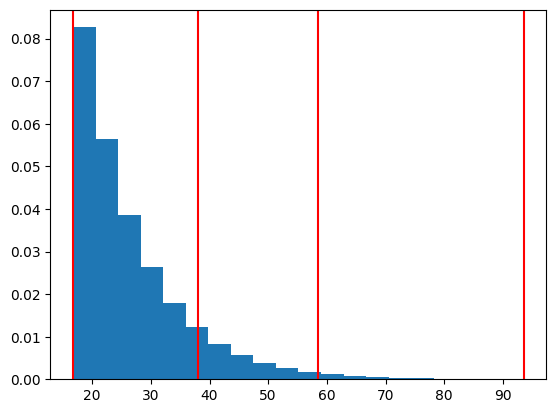

In [8]:
plt.hist(simulation.samples, density=True, bins=20)
for b in np.append(simulation.stratResults["Upper_X1"].values, simulation.stratResults["Lower_X1"].values[0]):
    plt.axvline(x = b, color = 'r')

## Step 3: Running the Optimum Power Flow

Running multiple iterations, to achieve EENS, ELOL
[#TODO Write Paragraph, Calculation of interations (based on init?)]
Creating the engine_database.csv <br>


In [ ]:
simulation.run(network, iterationSet = None, time = None, run_type = 'pm_ac_opf', delta = 1e-16, saveOutput = True)
# How are the Steps calculated? 4 stratas in initialize, but why 40 steps? (10 Steps each?)

In [9]:
# EXECUTE THIS, HIDDEN IN DOCS
simulation.run(network, iterationSet = None, time = None, run_type = 'pm_ac_opf', delta = 1e-16, saveOutput = True)
# How are the Steps calculated? 4 stratas in initialize, but why 40 steps? (10 Steps each?)

Strata = 0; Iteration = 0


100%|██████████| 40/40 [00:26<00:00,  1.54it/s]


Strata = 0; Iteration = 1


100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


Strata = 0; Iteration = 2


100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Strata = 0; Iteration = 3


100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Strata = 0; Iteration = 4


100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Strata = 0; Iteration = 5


 38%|███▊      | 15/40 [00:11<00:18,  1.33it/s]


Iteration 5 did not execute successfully. index 4 is out of bounds for axis 0 with size 4
Strata = 0; Iteration = 6


100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


Strata = 0; Iteration = 7


100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Strata = 0; Iteration = 8


100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Strata = 0; Iteration = 9


100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


Strata = 0; Iteration = 10


 38%|███▊      | 15/40 [00:11<00:18,  1.33it/s]


Iteration 10 did not execute successfully. index 4 is out of bounds for axis 0 with size 4
Strata = 0; Iteration = 11


100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


Strata = 0; Iteration = 12


100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Strata = 0; Iteration = 13


100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


Strata = 0; Iteration = 14


100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


Strata = 0; Iteration = 15


100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


Strata = 0; Iteration = 16


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Strata = 0; Iteration = 17


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Strata = 0; Iteration = 18


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Strata = 0; Iteration = 19


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Strata = 0; Iteration = 20


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Strata = 0; Iteration = 21


100%|██████████| 40/40 [00:35<00:00,  1.11it/s]


Strata = 0; Iteration = 22


100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


Strata = 0; Iteration = 23


100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


Strata = 0; Iteration = 24


100%|██████████| 40/40 [00:36<00:00,  1.08it/s]


Strata = 0; Iteration = 25


100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


Strata = 0; Iteration = 26


100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


Strata = 0; Iteration = 27


 32%|███▎      | 13/40 [00:12<00:25,  1.04it/s]


Iteration 27 did not execute successfully. index 4 is out of bounds for axis 0 with size 4
Strata = 0; Iteration = 28


100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


Strata = 0; Iteration = 29


100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


Strata = 0; Iteration = 30


100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Strata = 0; Iteration = 31


100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Strata = 0; Iteration = 32


100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Strata = 0; Iteration = 33


100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Strata = 0; Iteration = 34


100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


Strata = 0; Iteration = 35


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Strata = 0; Iteration = 36


100%|██████████| 40/40 [00:42<00:00,  1.07s/it]


Strata = 0; Iteration = 37


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


Strata = 0; Iteration = 38


100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


Strata = 0; Iteration = 39


100%|██████████| 40/40 [00:42<00:00,  1.05s/it]


Strata = 0; Iteration = 40


100%|██████████| 40/40 [00:44<00:00,  1.10s/it]


Strata = 0; Iteration = 41


100%|██████████| 40/40 [00:44<00:00,  1.11s/it]


Strata = 0; Iteration = 42


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


Strata = 0; Iteration = 43


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


Strata = 0; Iteration = 44


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


Strata = 0; Iteration = 45


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


Strata = 0; Iteration = 46


 30%|███       | 12/40 [00:12<00:30,  1.07s/it]


Iteration 46 did not execute successfully. index 4 is out of bounds for axis 0 with size 4
Strata = 0; Iteration = 47


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


Strata = 0; Iteration = 48


100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


Strata = 0; Iteration = 49


100%|██████████| 40/40 [00:47<00:00,  1.19s/it]


Strata = 0; Iteration = 50


100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Strata = 0; Iteration = 51


100%|██████████| 40/40 [15:45:02<00:00, 1417.56s/it]


Strata = 0; Iteration = 52


100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


Strata = 0; Iteration = 53


100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


Strata = 0; Iteration = 54


100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


Strata = 0; Iteration = 55


100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


Strata = 0; Iteration = 56


100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Strata = 0; Iteration = 57


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Strata = 0; Iteration = 58


100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Strata = 0; Iteration = 59


100%|██████████| 40/40 [00:55<00:00,  1.40s/it]


Strata = 0; Iteration = 60


100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


Strata = 0; Iteration = 61


100%|██████████| 40/40 [01:02<00:00,  1.55s/it]


Strata = 0; Iteration = 62


100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


Strata = 0; Iteration = 63


100%|██████████| 40/40 [00:51<00:00,  1.30s/it]


Strata = 0; Iteration = 64


100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Strata = 0; Iteration = 65


100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Strata = 0; Iteration = 66


 40%|████      | 16/40 [00:19<00:28,  1.21s/it]


Iteration 66 did not execute successfully. index 4 is out of bounds for axis 0 with size 4
Strata = 0; Iteration = 67


100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


Strata = 0; Iteration = 68


100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Strata = 0; Iteration = 69


100%|██████████| 40/40 [00:54<00:00,  1.35s/it]


Strata = 0; Iteration = 70


100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


Strata = 0; Iteration = 71


100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


Strata = 0; Iteration = 72


100%|██████████| 40/40 [00:55<00:00,  1.39s/it]


Strata = 0; Iteration = 73


100%|██████████| 40/40 [00:55<00:00,  1.40s/it]


Strata = 0; Iteration = 74


100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


Strata = 0; Iteration = 75


100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


Strata = 0; Iteration = 76


100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


Strata = 0; Iteration = 77


100%|██████████| 40/40 [00:58<00:00,  1.45s/it]


Strata = 0; Iteration = 78


100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


Strata = 0; Iteration = 79


100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


Strata = 0; Iteration = 80


100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


Strata = 0; Iteration = 81


100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


Strata = 0; Iteration = 82


100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


Strata = 0; Iteration = 83


100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


Strata = 0; Iteration = 84


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Strata = 0; Iteration = 85


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Strata = 0; Iteration = 86


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


Strata = 0; Iteration = 87


100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


Strata = 0; Iteration = 88


100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


Strata = 0; Iteration = 89


100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


Strata = 0; Iteration = 90


100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


Strata = 0; Iteration = 91


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


Strata = 0; Iteration = 92


100%|██████████| 40/40 [01:04<00:00,  1.60s/it]


Strata = 0; Iteration = 93


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


Strata = 0; Iteration = 94


100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


Strata = 0; Iteration = 95


100%|██████████| 40/40 [01:05<00:00,  1.65s/it]


Strata = 0; Iteration = 96


100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


Strata = 0; Iteration = 97


100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


Strata = 0; Iteration = 98


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Strata = 0; Iteration = 99


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Strata = 0; Iteration = 100


100%|██████████| 40/40 [01:09<00:00,  1.74s/it]


Strata = 0; Iteration = 101


100%|██████████| 40/40 [01:09<00:00,  1.75s/it]


Strata = 0; Iteration = 102


100%|██████████| 40/40 [01:17<00:00,  1.93s/it]


Strata = 0; Iteration = 103


100%|██████████| 40/40 [01:12<00:00,  1.80s/it]


Strata = 0; Iteration = 104


100%|██████████| 40/40 [01:11<00:00,  1.78s/it]


Strata = 0; Iteration = 105


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Strata = 0; Iteration = 106


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Strata = 0; Iteration = 107


100%|██████████| 40/40 [01:11<00:00,  1.78s/it]


Strata = 0; Iteration = 108


100%|██████████| 40/40 [01:12<00:00,  1.82s/it]


Strata = 0; Iteration = 109


100%|██████████| 40/40 [01:14<00:00,  1.85s/it]


Strata = 0; Iteration = 110


100%|██████████| 40/40 [01:14<00:00,  1.86s/it]


Strata = 0; Iteration = 111


100%|██████████| 40/40 [01:14<00:00,  1.86s/it]


Strata = 0; Iteration = 112


100%|██████████| 40/40 [01:14<00:00,  1.87s/it]


Strata = 0; Iteration = 113


100%|██████████| 40/40 [01:17<00:00,  1.94s/it]


Strata = 0; Iteration = 114


100%|██████████| 40/40 [01:15<00:00,  1.88s/it]


Strata = 0; Iteration = 115


 18%|█▊        | 7/40 [09:17<1:38:17, 178.71s/it]PowerModels.jl does not consider reactive power cost - costs are ignored


The network gets updated, printing latest iteration:

#### [Power Grid (post run)](../modeling/in_grid_modeling.md)

In [ ]:
pf_res_plotly(network.pp_network);
# How can we select a specific iteration?

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = simulation.failureProbs[simulation.failureProbs['element type']=='Line']
sns.lineplot(data=df, x='event intensity', y='failure probability', hue='power element')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
import pandas as pd
from utils import * # pplotting functions
df = pd.read_csv(rx.config.path.engineDatabaseFile(simulationName), index_col = [0, 1, 2, 3, 4])
# -> read database with results, BUT WHAT IS INDEX_COL FOR?

df = filter_non_converged_iterations(df) # filterining non-converged iterations

#### Line Data

In [ ]:
from utils import group_by, invert, get_quantiles_on_iterations
df_line = group_by(df.loc[3], 'sum', 'iteration', 'field', 'type').loc[:,:,'line']
df_line_quantiles = invert(get_quantiles_on_iterations(df_line, [0.05,0.5,0.95]))
df_line = invert(df_line)

In [ ]:
df_montecarlo = pd.read_csv(rx.config.path.engineDatabaseFile(simulationName), index_col = [0, 1, 2, 3, 4])

In [ ]:
import plotly.express as px
px.line(df_line, x=df_line.index, y = 'in_service', color = 'iteration')
# Number of lines in Service!

In [ ]:
px.line(df_line_quantiles, x=df_line_quantiles.index, y = 'in_service', color = 'quantile')
# Quantiles of lines in service

In [ ]:
df_load = group_by(filter(df, type = 'load'), 'sum', 'iteration', 'field', 'type')
df_load_quantiles = invert(get_quantiles_on_iterations(df_load, [0.05, 0.25, 0.5, 0.75, 0.95]))
# df_load = invert(df_load) 
# df_load['loss_of_load_p_percentage'] = (df_load['loss_of_load_p_mw'])/df_load['max_p_mw'] *100
df_load_quantiles['loss_of_load_p_percentage'] = (df_load_quantiles['loss_of_load_p_mw'])/df_load_quantiles['max_p_mw'] *100

In [ ]:
px.line(df_load_quantiles, x=df_load_quantiles.index, y = 'loss_of_load_p_percentage', color = 'quantile')

### MC METRICS?

In [ ]:
df_network_condensed = filter(df, type = 'network').sum(axis = 1) # sum over timesteps

In [ ]:
df_network_condensed_ = invert(df_network_condensed)
px.histogram(df_network_condensed_, x='energy_not_served_mwh', histnorm='probability')

In [ ]:
statistics= df_network_condensed.groupby('field').mean() # average over iterations
EENS = statistics['energy_not_served_mwh']
LOLE = statistics['loss_of_load_p_duration_h']
print(f'EENS : {EENS.round(2)} MWh, LOLE : {LOLE.round(2)} h')

In [ ]:
crt_loss_of_load = 30 
df_loss_of_load = df.loc[:,:,"loss_of_load_p_percentage","network"]
Survivability = pd.DataFrame(1 - (df_loss_of_load > crt_loss_of_load).sum() / df_loss_of_load.index.levels[0].size, columns = ['base case'])

In [ ]:
df_aux = pd.read_csv(rx.config.path.engineDatabaseFile('basic_example_v1'), index_col = [0, 1, 2, 3])
df_loss_of_load_aux = df_aux.loc[:,"loss_of_load_p_percentage","network"]
Survivability['line 10 reinforced'] = 1 - (df_loss_of_load_aux > crt_loss_of_load).sum() / df_loss_of_load_aux.index.levels[0].size
df_aux = pd.read_csv(rx.config.path.engineDatabaseFile('basic_example_v2'), index_col = [0, 1, 2, 3])
df_loss_of_load_aux = df_aux.loc[:,"loss_of_load_p_percentage","network"]
Survivability['line 2 reparing time improved'] = 1 - (df_loss_of_load_aux > crt_loss_of_load).sum() / df_loss_of_load_aux.index.levels[0].size

In [ ]:
px.line(Survivability).update_layout(xaxis_title="time", yaxis_title="Survivability")

In [ ]:
px.line(df_load_quantiles, x=df_load_quantiles.index, y = 'loss_of_load_p_percentage', color = 'quantile')

In [ ]:
import plotly.graph_objects as go
df_line = group_by(filter(df, type = 'line'), 'mean','strata', 'iteration', 'field','id') # mean in this case does not have any effect as the groupying levels are the initial ones
df_line = invert(df_line)
# df_line = df_line.loc[df_line.index > '2022-01-01 12:00:00']

fig = go.Figure() # --> put in a function (?)

ids = df_line['id'].drop_duplicates().to_list()

for id in ids:
    fig.add_trace(go.Violin(x=df_line['id'][df_line['id'] == id],
                            y=df_line['loading_percent'][df_line['id'] == id],
                            name=id,
                            box_visible=False,
                            meanline_visible=True,
                            side='positive',
                            orientation = 'v'
                           )
                 )
fig.update_layout(width=1000, height=500)
fig.show()
